In [10]:
import pandas as pd
import numpy as np
from scipy.stats import gmean
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('paper_style.mplstyle')

colors = {
    'dred':    '#c54e52', 'lred':    '#f8b1bb',
    'dblue':   '#3c5488', 'lblue':   '#bfd6ef',
    'dgreen':  '#00a087', 'lgreen':  '#c0e6ea',
    'dpink':   '#d78bbb', 'lpink':   '#f9d5e5',
    'dyellow': '#ccb974', 'lyellow': '#fff0c1',
    'gray': '#c0c0c0'}

# qPCR depletion

In [69]:
qpcr_fraction = pd.read_csv(
    'datasets/depletion_qpcr.csv', index_col=0)

list_order = [
    'yes enzyme, no guide',
    'yes enzyme, miss 1',
    'yes enzyme, miss 2',
    'yes enzyme, yes guide',
    'fen1, yes guide',
    'yes enzyme, yes guide, ds',
    'no enzyme, no guide',]

supp_means = qpcr_fraction.loc[
    list_order,
    ['mean']].reset_index()

supp_replicates = qpcr_fraction.loc[
    list_order,
    ['r1', 'r2', 'r3']]

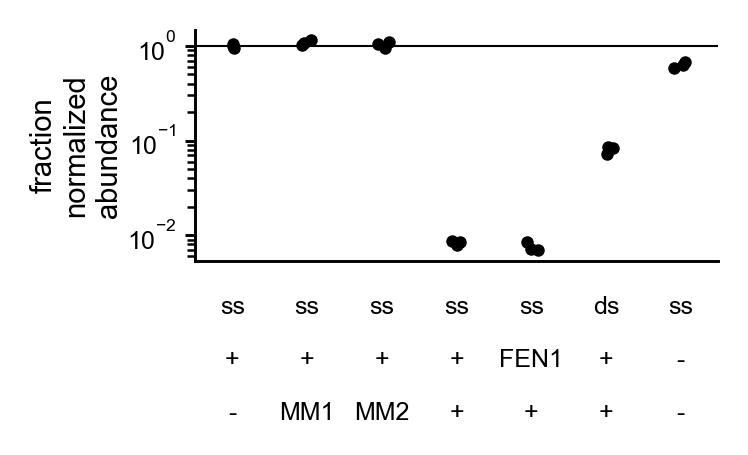

In [70]:
output_dir = 'outputs/figures'
output_name = 'S1D_depletion_rRNA.pdf'


fig, ax = plt.subplots(figsize=(2.25, 1))

sns.stripplot(
    ax=ax,
    data=supp_replicates.melt(ignore_index=False).reset_index(),
    y='value',
    x='index',
    size=3,
    color='k',)

plt.yscale('log')
ax.axhline(1, 0, 1, lw=0.5, color='k')

# rows will be target, enzyme, guide

ax.set_xticks(
    [0, 1, 2, 3, 4, 5, 6],
    ['\nss\n\n+\n\n-',
     '\nss\n\n+\n\nMM1',
     '\nss\n\n+\n\nMM2',
     '\nss\n\n+\n\n+',
     '\nss\n\nFEN1\n\n+',
     '\nds\n\n+\n\n+',
     '\nss\n\n-\n\n-'])
ax.set_ylabel('fraction\nnormalized\nabundance')
ax.set_xlabel('')
ax.tick_params(axis='x', length=0)
sns.despine()

# save figure
plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight')

# rRNA depletion

In [65]:
gene_table = pd.read_csv(
    'datasets/gt_mtb_h37rv.csv', index_col=0)

CDS_geneid = gene_table.index[gene_table.locus_type == 'CDS']
rRNA_geneid = gene_table.index[gene_table.locus_type == 'rRNA']

In [66]:
isolate_counts = pd.read_csv(
    'rnaseq/isolate_counts.csv', index_col=0).T
validation_counts = pd.read_csv(
    'rnaseq/validation_counts.csv', index_col=0).T
all_counts = pd.concat([
    isolate_counts, validation_counts], axis=1)

total_rrna = all_counts.loc[rRNA_geneid].sum(0) / all_counts.sum(0) * 100
total_cds  = all_counts.loc[CDS_geneid].sum(0) / all_counts.sum(0) * 100

8.598160453822645 87.44744811777862


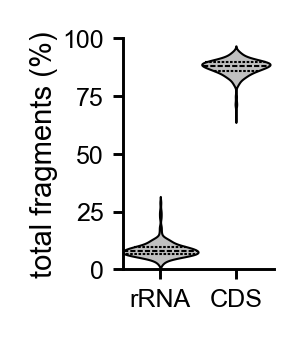

In [68]:
output_dir = 'outputs/figures'
output_name = '1C_rRNA_vs_CDS.pdf'

print(np.mean(total_rrna), np.mean(total_cds))

plot_df = pd.DataFrame(
    data=np.asarray([
        np.r_[['rRNA' for i in range(len(total_rrna))],
              ['CDS' for i in range(len(total_cds))]],
        np.r_[total_rrna, total_cds]]).T,
    columns=['region', 'percent'])

plot_df.percent = plot_df.percent.astype(float)


fig, ax = plt.subplots(figsize=(0.65, 1))

sns.violinplot(
    data=plot_df,
    x='region',
    y='percent',
    color='silver',
    width=1.,
    linewidth=0.5,
    linecolor='k',
    inner='quart')

ax.set_ylim(0, 100)
ax.set_ylabel('total fragments (%)')
ax.set_xlabel('')
sns.despine()

# save figure
plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight')

# Normalize Validation Dataset

In [25]:
# load in counts df and add a pseudocount
counts_df = pd.read_csv(
    'rnaseq/validation/validation_counts.csv',
    index_col=0, header=0).T + 1
# rename columns
counts_df.columns = pd.MultiIndex.from_tuples(
    [val.split('_') for val in counts_df.columns], names=('lineage', 'replicate', 'rna_input'))
# remove rRNA reads
counts_df = counts_df.loc[
    ~np.isin(counts_df.index, ['Rvnr01', 'Rvnr02', 'Rvnr03'])]
# generate a reference sample
reference_sample = gmean(counts_df, axis=1)
# divide gene counts by the reference sample
ratio_to_ref_df = counts_df / reference_sample.reshape(-1, 1)
# get the median of each sample
size_factor = np.nanmedian(ratio_to_ref_df, axis=0)
# normalize counts
normalized_counts_df = np.log2(counts_df / size_factor)

# save normalized counts
normalized_counts_df.to_csv(
    'rnaseq/normalized_validation_expression.csv')

# Normalize Isolate Dataset

In [29]:
# load in counts df and add a pseudocount
counts_df = pd.read_csv(
    'rnaseq/isolate_counts.csv',
    index_col=0, header=0).T + 1
# rename columns
counts_df.columns = pd.MultiIndex.from_tuples(
    [(val, val[:7], val[-1:]) for val in counts_df.columns], names=('sample', 'strain', 'replicate'))
# remove rRNA reads
counts_df = counts_df.loc[
    ~np.isin(counts_df.index, ['Rvnr01', 'Rvnr02', 'Rvnr03'])]
# generate a reference sample
reference_sample = gmean(counts_df, axis=1)
# divide gene counts by the reference sample
ratio_to_ref_df = counts_df / reference_sample.reshape(-1, 1)
# get the median of each sample
size_factor = np.nanmedian(ratio_to_ref_df, axis=0)
# normalize counts
normalized_counts_df = np.log2(counts_df / size_factor)

# save normalized counts
normalized_counts_df.to_csv(
    'rnaseq/normalized_isolate_expression.csv')

# Validation PCA

In [4]:
exp_data_path = 'rnaseq/normalized_validation_expression.csv'
validation_data = pd.read_csv(
    exp_data_path,
    header=[0, 1, 2], index_col=0)

exp_cutoff = 50
std_cutoff = 75

# apply expression cutoff
mean_gene_exp = validation_data.mean(1)
kept_genes = mean_gene_exp.index[
    mean_gene_exp >= np.percentile(mean_gene_exp, exp_cutoff)]

# apply std cutoff
gene_std = np.std(validation_data.loc[kept_genes], 1)
kept_genes = gene_std.index[
    gene_std >= np.percentile(gene_std, std_cutoff)]

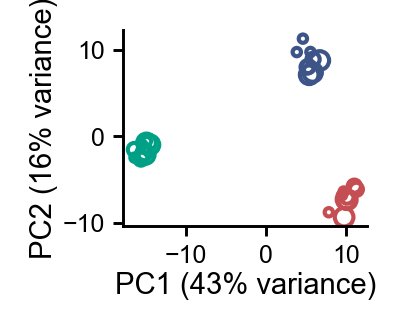

In [11]:
output_dir = 'outputs/figures'
output_name = '1D_validation_PCA.pdf'

pca_input = validation_data.loc[kept_genes].T

# fit a model
model = PCA(n_components=10)
model.fit(pca_input)
transform = model.transform(pca_input)

fig, ax = plt.subplots(figsize=(1.05, 0.85))
# draw samples in PCA space
ax.scatter(
    transform[:, 0], transform[:, 1],
    facecolor='none',
    s=validation_data.columns.get_level_values('rna_input').map(
        {'100ng': 20, '50ng': 10, '10ng': 4}),
    edgecolors=validation_data.columns.get_level_values('lineage').map(
        {'l1': colors['dgreen'], 'l2': colors['dblue'], 'l4': colors['dred']}))
# ax.set_yticks([-4, 0, 4, 8])
ax.set_xlabel(
    f'PC1 ({int(np.round(100*model.explained_variance_ratio_[0], 0))}% variance)')
ax.set_ylabel(
    f'PC2 ({int(np.round(100*model.explained_variance_ratio_[1], 0))}% variance)')

sns.despine()

plt.savefig(
    f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

# Validation Heatmap

In [58]:
exp_data_path = 'rnaseq/normalized_validation_expression.csv'
validation_data = pd.read_csv(
    exp_data_path,
    header=[0, 1, 2], index_col=0)

exp_cutoff = 50

# apply expression cutoff
mean_gene_exp = validation_data.mean(1)
kept_genes = mean_gene_exp.index[
    mean_gene_exp >= np.percentile(mean_gene_exp, exp_cutoff)]

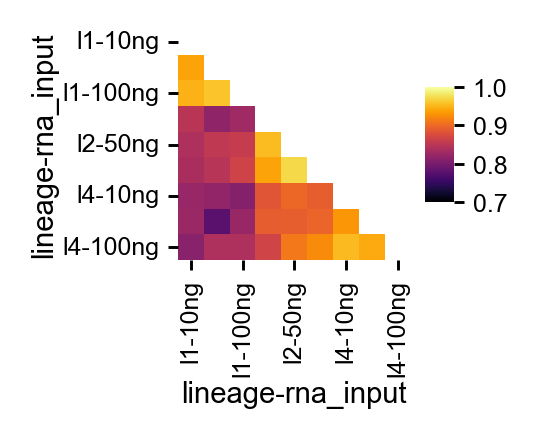

In [59]:
output_dir = 'outputs/figures'
output_name = '1E_validation_heatmap.pdf'

exp_cutoff = 50

fig, ax = plt.subplots(figsize=(1.25, 1.0))

# generate pearson correlation heatmap
correlation_matrix = validation_data.T.groupby(
    ['lineage', 'rna_input']).mean().T.loc[
    kept_genes, pd.IndexSlice[['l1', 'l2', 'l4'], ['10ng', '50ng', '100ng']]].corr()
mask = np.ones(correlation_matrix.shape).astype(bool)
mask[np.tril_indices(correlation_matrix.shape[0], -1)] = False
correlation_matrix.values[mask] = np.nan

sns.heatmap(
    correlation_matrix,
    vmin=0.7,
    vmax=1,
    cmap='inferno',
    cbar_kws={'aspect': 4, 'shrink': .5, 'ticks':[0.7, 0.8, 0.9, 1]})
# save figure
plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight')